# Axis Tuning

In [1]:
import math
import numpy as np
import socket
import time

# Import matplotlib and put it in interactive mode.
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

from ophyd.scaler import ScalerCH
from ophyd import EpicsMotor, EpicsSignal
from bluesky import RunEngine
from bluesky.callbacks.best_effort import BestEffortCallback
import bluesky.plans as bp 
# Make plots update live while scans run.
from bluesky.utils import install_nb_kicker
install_nb_kicker()

from APS_BlueSky_tools.synApps_ophyd import userCalcsDevice, swait_setup_lorentzian


hostname = socket.gethostname()

HOST_PV_PREFIX_DICT = {
    'otz.aps.anl.gov': "gov:",
    'mint-vm': "prj:",
    'poof': "prj:",
    'enoki': "prj:",
    }
IOC_PREFIX = HOST_PV_PREFIX_DICT.get(hostname, "xxx:")


RE = RunEngine({})
RE.subscribe(BestEffortCallback())


def setRandomPeak(calc, motor):
    swait_setup_lorentzian(
        calc, 
        motor, 
        center = -1.5 + 0.5*np.random.uniform(), 
        noise  = 0.2  + 0.2*np.random.uniform(), 
        width  = 0.001 + 0.05*np.random.uniform(), 
        scale  = 1e5,
        )

In [2]:
from APS_BlueSky_tools.devices import AxisTunerMixin
from APS_BlueSky_tools.plans import TuneAxis


class TunableEpicsMotor(EpicsMotor, AxisTunerMixin):
    pass


m1 = TunableEpicsMotor(IOC_PREFIX+"m1", name="m1")
calcs = userCalcsDevice(IOC_PREFIX, name="calcs")
time.sleep(1)

In [3]:
# change soft motor resolution from 200 steps/rev to 8000 (steps of 0.00025)
_srev = EpicsSignal(m1.prefix+".SREV", name="_srev")
_srev.put(8000)

In [4]:
noisy_calc = calcs.calc1
setRandomPeak(noisy_calc, m1)

print("programmed peak signal: {}".format(calcs.calc1.channels.D.value.value))
print("programmed center: {}".format(calcs.calc1.channels.B.value.value))
sigma = calcs.calc1.channels.C.value.value
fwhm = 2*math.sqrt(2* sigma**2 * math.log(2))
print("programmed sigma: {}".format(sigma))
print("programmed FWHM: {}".format(fwhm))
print("programmed noise: {}".format(calcs.calc1.channels.E.value.value))

programmed peak signal: 100000.0
programmed center: -1.4446590506594514
programmed sigma: 0.02168093829234859
programmed FWHM: 0.05105470808590154
programmed noise: 0.3346180806624174


In [5]:
noisy = EpicsSignal(noisy_calc.prefix, name="noisy")

In [6]:
m1.tuner = TuneAxis([noisy], m1, signal_name=noisy.name)
# m1.tuner = MyTuneAxis([det], m1, signal_name="det")
m1.tuner.width = 5
m1.tuner.num = 21

m1.move(0)

MoveStatus(done=True, pos=m1, elapsed=0.2, success=True, settle_time=0.0)

m1 position before tuning: 0.0
Transient Scan ID: 1     Time: 2018/09/20 13:24:24
Persistent Unique Scan ID: '601b60d2-fb96-4f4e-bd8d-0c56f4b1c342'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         m1 |      noisy |
+-----------+------------+------------+------------+


<IPython.core.display.Javascript object>


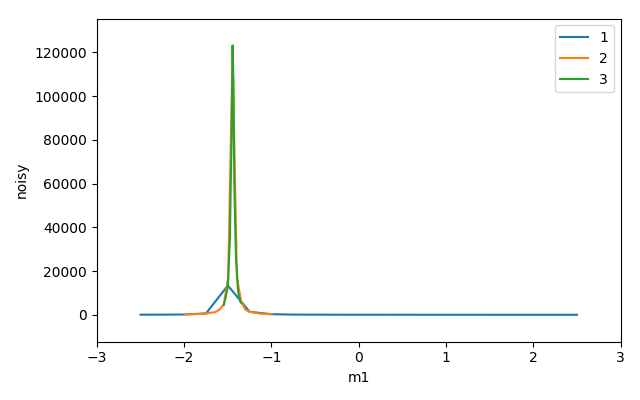

|         1 | 13:24:24.9 |   -2.50000 |   48.94554 |
|         2 | 13:24:24.9 |   -2.25000 |   70.96710 |
|         3 | 13:24:25.0 |   -2.00000 |  149.88108 |
|         4 | 13:24:25.1 |   -1.75000 |  621.65429 |
|         5 | 13:24:25.2 |   -1.50000 | 13396.85222 |
|         6 | 13:24:25.3 |   -1.25000 | 1367.22809 |
|         7 | 13:24:25.4 |   -1.00000 |  288.16114 |
|         8 | 13:24:25.6 |   -0.75000 |   95.13812 |
|         9 | 13:24:25.7 |   -0.50000 |   61.84400 |
|        10 | 13:24:25.8 |   -0.25000 |   37.02767 |
|        11 | 13:24:25.9 |    0.00000 |   22.28995 |
|        12 | 13:24:26.0 |    0.25000 |   20.37557 |
|        13 | 13:24:26.1 |    0.50000 |   15.67441 |
|        14 | 13:24:26.2 |    0.75000 |   11.80968 |
|        15 | 13:24:26.3 |    1.00000 |    8.15058 |
|        16 | 13:24:26.4 |    1.25000 |    7.76643 |
|        17 | 13:24:26.5 |    1.50000 |    6.04243 |
|        18 | 13:24:26.6 |    1.75000 |    5.33433 |
|        19 | 13:24:26.7 |    2.00000 |    3.

('601b60d2-fb96-4f4e-bd8d-0c56f4b1c342',)

In [7]:
RE(m1.tune())

In [8]:
m1.tuner.width /= 5
RE(m1.tune())

m1 position before tuning: -1.496
Transient Scan ID: 2     Time: 2018/09/20 13:24:27
Persistent Unique Scan ID: '838e874a-6a8e-4b34-89bc-91a6a4ffec4a'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         m1 |      noisy |
+-----------+------------+------------+------------+
|         1 | 13:24:27.6 |   -1.99600 |  173.15670 |
|         2 | 13:24:27.7 |   -1.94600 |  228.98558 |
|         3 | 13:24:27.8 |   -1.89600 |  274.15620 |
|         4 | 13:24:27.9 |   -1.84600 |  328.35014 |
|         5 | 13:24:28.0 |   -1.79600 |  438.60795 |
|         6 | 13:24:28.1 |   -1.74600 |  626.58058 |
|         7 | 13:24:28.2 |   -1.69600 |  940.30124 |
|         8 | 13:24:28.3 |   -1.64600 | 1214.41741 |
|         9 | 13:24:28.4 |   -1.59600 | 2341.69156 |
|        10 | 13:24:28.5 |   -1.54600 | 4896.67473 |
|        11 | 13:24:28.6 |   -1.49600 | 16906.57892 |
|        12 | 13:24:28.7 |   -1.44600 | 119863.39444 |
|        13 | 13:24:28.8 |   

('838e874a-6a8e-4b34-89bc-91a6a4ffec4a',)

In [9]:
m1.tuner.width /= 5
RE(m1.tune())

m1 position before tuning: -1.446
Transient Scan ID: 3     Time: 2018/09/20 13:24:29
Persistent Unique Scan ID: 'ba295d28-3efa-407e-a9c3-0f3eb5876238'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         m1 |      noisy |
+-----------+------------+------------+------------+
|         1 | 13:24:30.0 |   -1.54600 | 4456.38738 |
|         2 | 13:24:30.1 |   -1.53600 | 6201.40216 |
|         3 | 13:24:30.2 |   -1.52600 | 7732.91688 |
|         4 | 13:24:30.3 |   -1.51600 | 10021.89129 |
|         5 | 13:24:30.4 |   -1.50600 | 11553.97981 |
|         6 | 13:24:30.5 |   -1.49600 | 16113.89578 |
|         7 | 13:24:30.6 |   -1.48600 | 26299.01672 |
|         8 | 13:24:30.7 |   -1.47600 | 34871.01037 |
|         9 | 13:24:30.8 |   -1.46600 | 61322.34146 |
|        10 | 13:24:30.9 |   -1.45600 | 81217.62434 |
|        11 | 13:24:31.0 |   -1.44600 | 123225.56244 |
|        12 | 13:24:31.1 |   -1.43600 | 107253.37586 |
|        13 | 13:24:3

('ba295d28-3efa-407e-a9c3-0f3eb5876238',)